#### Optimización de función de temperatura con Algoritmos Genéticos

In [45]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from deap import base, creator, tools, algorithms

#### Definición de los parámetros, funciones y configuración del GA

In [46]:
# --- 1. Definición del Problema ---
# INPUT: (hora (formato 24 hs), temperatura de la sup. terrestre en grados Celsius)
points = [(1, 11), (10, 12), (13, 34), (22, 28)] # Datos tomados de 2 satélites diferentes

# Límites para los coeficientes del polinomio
BOUND_LOW, BOUND_UP = -20.0, 50.0 # Elegimos estos límites para que tenga cierta flexibilidad para buscar pero a la vez que no sea un espacio demasiado grande
N_VARIABLES = 4  # 4 coeficientes (a, b, c, d) porque estamos usando un polinomio cúbico

# Defino mi función fitness
def evalPolynomial(individual, points):
    """
    Evalúa el error de un polinomio cúbico.
    Individuo: [a, b, c, d] coeficientes del polinomio
    """
    a, b, c, d = individual
    
    # Calcular error (suma de cuadrados)
    error = 0.0
    for x, y in points:
        y_pred = a*x**3 + b*x**2 + c*x + d
        error += (y - y_pred)**2
    
    return (error,)

In [47]:
# --- 2. Configuración de DEAP (para individuos decimales)---
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Weights -1 porque queremos minimizar la función fitness
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Atributo generador de los individuos: valores float en el rango [BOUND_LOW, BOUND_UP]
for i in range(N_VARIABLES):
    toolbox.register(f"attr_float_{i}", random.uniform, BOUND_LOW, BOUND_UP)

# Crear individuos: lista de 4 floats [a, b, c, d]
toolbox.register("individual", tools.initCycle, creator.Individual,
                [toolbox.attr_float_0, toolbox.attr_float_1, 
                 toolbox.attr_float_2, toolbox.attr_float_3], n=1)
# Crear la población (lista de individuos)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def checkBounds(individual):
    """Asegura que los valores estén dentro de los límites."""
    for i in range(len(individual)):
        individual[i] = max(BOUND_LOW, min(BOUND_UP, individual[i]))
    return individual

# Definimos los operadores genéticos
toolbox.register("evaluate", evalPolynomial, points=points) # Registro mi función fitness
toolbox.register("mate", tools.cxBlend, alpha=0.5) # Defino el mecanismo de cruza: Blend crossover 
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2) # Mutación gaussiana
toolbox.register("select", tools.selTournament, tournsize=3) # Elegimos selección por torneo


/Users/ari/opt/miniconda3/envs/ae-env/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/ari/opt/miniconda3/envs/ae-env/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [48]:
# --- 3. Creamos una función para ejecutar el GA ---
def run_ga(points, pop_size=100, cruceprob=0.7, mutacionprob=0.2, 
           ngen=500, seed=42, verbose=True):
    """Ejecutar el algoritmo genético con los parámetros de entrada."""
    random.seed(seed)
    np.random.seed(seed)
    
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1) # Guardo solo el mejor progenitor de todos
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)
    
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=cruceprob, mutpb=mutacionprob, 
                                       ngen=ngen, stats=stats, 
                                       halloffame=hof, verbose=verbose)
    
    return pop, logbook, hof

---
#### Ejecución única del Algoritmo Genético con los siguientes hiperparámetros:
- Población: 200 individuos
- Generaciones: 500
- cruceprob=0.7, 
- mutacionprob=0.2

In [49]:
# --- 4. Ejecución del Algoritmo Genético (única) ---
print("=== Ejecución única del GA ===\n")
pop, logbook, hof = run_ga(points, pop_size=200, ngen=500, seed=42)

best_ind = hof[0] # Tomo el primer elemento de la lista del hall de la fama que es el mejor
a, b, c, d = best_ind # Separo cada coeficiente

print("\n--- Resultados ---")
print(f"Mejor individuo:")
print(f"  a = {a:.10f}")
print(f"  b = {b:.10f}")
print(f"  c = {c:.10f}")
print(f"  d = {d:.10f}")
print(f"Fitness (error): {best_ind.fitness.values[0]:.10f}")

# Verificación (comparo los valores reales con los calculados con el polinomio)
print("\nVerificación de paso por los puntos (datos de Temperatura) que tenía como entrada:")
for x, y in points:
    y_pred = a*x**3 + b*x**2 + c*x + d
    error = (y - y_pred)**2
    print(f"  x={x}, y_real={y}, y_pred={y_pred:.4f}, error={error:.6e}")



=== Ejecución única del GA ===

gen	nevals	min        	avg        
0  	200   	7.75335e+06	8.17833e+10
1  	146   	8.82686e+06	2.07254e+10
2  	160   	5.84659e+06	4.61667e+09
3  	147   	2.07105e+06	6.57118e+08
4  	145   	852347     	2.16689e+08
5  	160   	193601     	9.44353e+07
6  	161   	23730.3    	5.07226e+07
7  	151   	23445.6    	3.96484e+07
8  	164   	23445.6    	3.43016e+07
9  	162   	23445.6    	3.41909e+07
10 	153   	13701      	2.50996e+07
11 	156   	13701      	3.17202e+07
12 	148   	4466.1     	2.17894e+07
13 	159   	4466.1     	1.84313e+07
14 	162   	4466.1     	2.13753e+07
15 	162   	12015.7    	1.35558e+07
16 	138   	9156.13    	1.25506e+07
17 	156   	2262.53    	8.42964e+06
18 	159   	4676.62    	5.15528e+06
19 	158   	2592.13    	1.46125e+07
20 	151   	2592.13    	4.73349e+06
21 	149   	2380.03    	1.04955e+07
22 	161   	1995.3     	2.94488e+06
23 	138   	810.648    	2.27439e+06
24 	158   	913.485    	7.99653e+06
25 	153   	913.485    	6.7109e+06 
26 	154   	1063.73    	

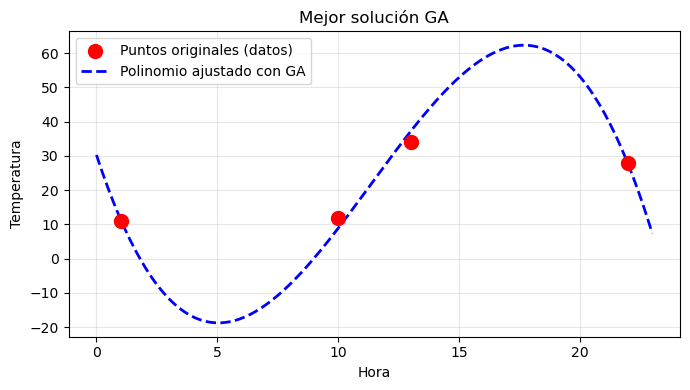

In [50]:
# --- 5. Visualización ---

# Creamos una función para graficar la curva ajustada y los datos originales
def plot_solucion(coef, points, title="Mejor solución GA"):
    """Grafica la solución encontrada."""
    a, b, c, d = coef
    xs = np.linspace(min(x for x, _ in points) - 1, 
                     max(x for x, _ in points) + 1, 200)
    ys = a * xs**3 + b * xs**2 + c * xs + d
    
    plt.figure(figsize=(7, 4))
    plt.scatter(*zip(*points), color='red', label='Puntos originales (datos)', s=100, zorder=3)
    plt.plot(xs, ys, color='blue', linestyle='--', label='Polinomio ajustado con GA', linewidth=2)
    plt.legend()
    plt.xlabel("Hora")
    plt.ylabel("Temperatura")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Ejecuto la función 
# best_ind son los coeficientes del mejor individuo
# points son los datos originales
plot_solucion(best_ind, points)

#### Curva de convergencia del GA para la ejecución única

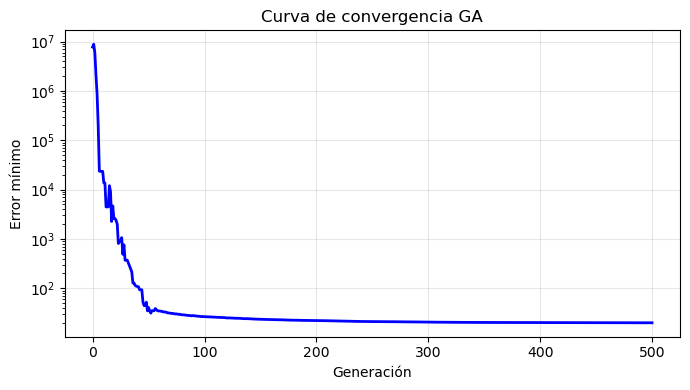

In [51]:
# Curva de convergencia
gen = logbook.select("gen")
fit_mins = logbook.select("min")

plt.figure(figsize=(7, 4))
plt.plot(gen, fit_mins, color='blue', linewidth=2)
plt.xlabel("Generación")
plt.ylabel("Error mínimo")
plt.title("Curva de convergencia GA")
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Observación sobre esta ejecución: el algoritmo converge rápidamente, pero no logra un error muy bajo. Posiblemente se deba a que la población es pequeña y no hay suficiente diversidad genética.

---
#### Ejecuciones múltiples del GA

In [ ]:
# --- 6. Evaluación con múltiples trials ---

# Creo una función que me permite calcular múltiples ensayos del mismo GA (30 veces por defecto)
def run_multiple_trials(points, num_trials=30, pop_size=200, ngen=500, cruceprob=0.7, mutacionprob=0.2,
                       base_seed=42, titulo='Base'):
    """Ejecuta múltiples trials del GA."""
    print(f"\n{'='*60}")
    print(f"Prueba '{titulo}' - {num_trials} trials")
    print(f"{'='*60}")
    
    final_errors = []
    convergence_curves = []
    best_overall = None
    min_error = float('inf')
    
    for trial in range(num_trials):
        seed = base_seed + trial
        pop, logbook, hof = run_ga(points, pop_size=pop_size, 
                                   ngen=ngen, seed=seed, cruceprob=cruceprob, mutacionprob=mutacionprob, verbose=False)
        
        best_ind = hof[0]
        error = best_ind.fitness.values[0]
        final_errors.append(error)
        
        fit_mins = logbook.select("min")
        convergence_curves.append(fit_mins)
        
        print(f"  Trial {trial+1:2d} (seed={seed:3d}): Error = {error:.6e}")
        
        if error < min_error:
            min_error = error
            best_overall = list(best_ind)
    
    return final_errors, convergence_curves, best_overall


---
#### Pruebas de consistencia y estabilidad

Analizamos 3 variantes del GA (A, B y C) con diferentes hiperparámetros (se varía el tamaño de población y el nro de generaciones) y comparamos sus resultados. Cada variante se ejecuta 30 veces.

In [ ]:
# --- 7. Configuraciones de Algoritmos ---
print("\n" + "="*60)
print("EVALUACIÓN DE HIPERPARÁMETROS")
print("="*60)

# Algoritmo A: 
errors_A, curves_A, coef_A = run_multiple_trials(
    points, num_trials=30, pop_size=150, ngen=400, cruceprob=0.7, mutacionprob=0.2, titulo='Algoritmo_A')

# Algoritmo B: 
errors_B, curves_B, coef_B = run_multiple_trials(
    points, num_trials=30, pop_size=250, ngen=600, cruceprob=0.8, mutacionprob=0.2, titulo='Algoritmo_B')

# Algoritmo C: 
errors_C, curves_C, coef_C = run_multiple_trials(
    points, num_trials=30, pop_size=400, ngen=800, cruceprob=0.8, mutacionprob=0.1, titulo='Algoritmo_C')



EVALUACIÓN DE HIPERPARÁMETROS

Prueba 'Algoritmo_A' - 30 trials
  Trial  1 (seed= 42): Error = 2.312951e+03
  Trial  2 (seed= 43): Error = 1.377123e+03
  Trial  3 (seed= 44): Error = 7.313785e+01
  Trial  4 (seed= 45): Error = 7.312057e+02
  Trial  5 (seed= 46): Error = 1.933885e+03
  Trial  6 (seed= 47): Error = 1.921578e+03
  Trial  7 (seed= 48): Error = 1.288674e+02
  Trial  8 (seed= 49): Error = 3.687378e+03
  Trial  9 (seed= 50): Error = 1.119172e+03
  Trial 10 (seed= 51): Error = 3.757219e+02
  Trial 11 (seed= 52): Error = 9.089991e+00
  Trial 12 (seed= 53): Error = 1.726602e+03
  Trial 13 (seed= 54): Error = 3.773802e+01
  Trial 14 (seed= 55): Error = 3.289902e+02
  Trial 15 (seed= 56): Error = 4.008552e+01
  Trial 16 (seed= 57): Error = 4.140252e+03
  Trial 17 (seed= 58): Error = 7.665771e+00
  Trial 18 (seed= 59): Error = 2.236640e+02
  Trial 19 (seed= 60): Error = 1.334338e+01
  Trial 20 (seed= 61): Error = 1.300206e+03
  Trial 21 (seed= 62): Error = 1.254030e+02
  Trial 22 

#### Tabla comparativa de resultados de las 3 variantes de GA

In [54]:
# --- 8. Armamos una tabla comparativa ---
data = {
    'Algoritmo': ['Algoritmo_A', 'Algoritmo_B', 'Algoritmo_C'],
    'Mínimo': [np.min(errors_A), np.min(errors_B), np.min(errors_C)],
    'Promedio': [np.mean(errors_A), np.mean(errors_B), np.mean(errors_C)],
    'Máximo': [np.max(errors_A), np.max(errors_B), np.max(errors_C)],
    'Desviación estándar': [np.std(errors_A), np.std(errors_B), np.std(errors_C)]
}
df = pd.DataFrame(data)
print("\n" + "="*60)
print("TABLA COMPARATIVA DE RESULTADOS")
print("="*60)
# print(df.to_string(index=False))
df.head()



TABLA COMPARATIVA DE RESULTADOS


,Algoritmo,Mínimo,Promedio,Máximo,Desviación estándar
0,Algoritmo_A,7.665771,992.490562,4727.262368,1283.246943
1,Algoritmo_B,0.006764,466.341129,4976.706721,951.882043
2,Algoritmo_C,0.984722,326.002091,1709.171777,441.036111


#### Boxplots para comparar la distribución de los resultados para las 3 variantes

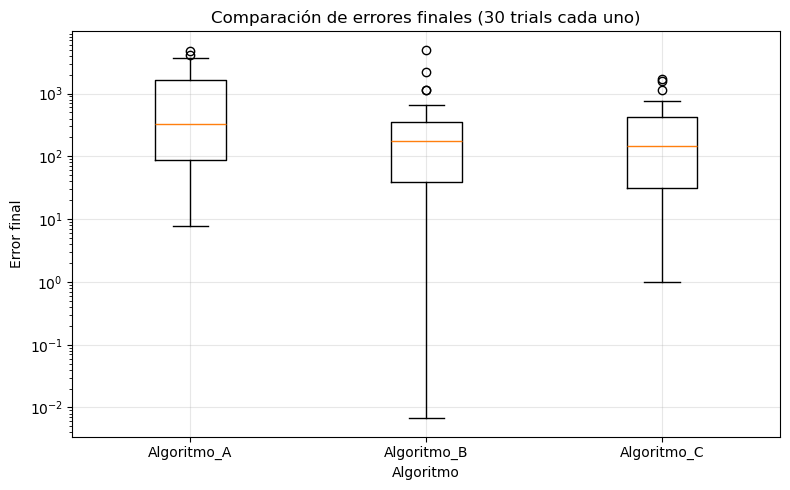

In [55]:
# --- 9. Boxplots ---
plt.figure(figsize=(8, 5))
plt.boxplot([errors_A, errors_B, errors_C], 
            tick_labels=['Algoritmo_A', 'Algoritmo_B', 'Algoritmo_C'])
plt.xlabel("Algoritmo")
plt.ylabel("Error final")
plt.title("Comparación de errores finales (30 trials cada uno)")
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Gráficos de convergencia promedio para cada variante

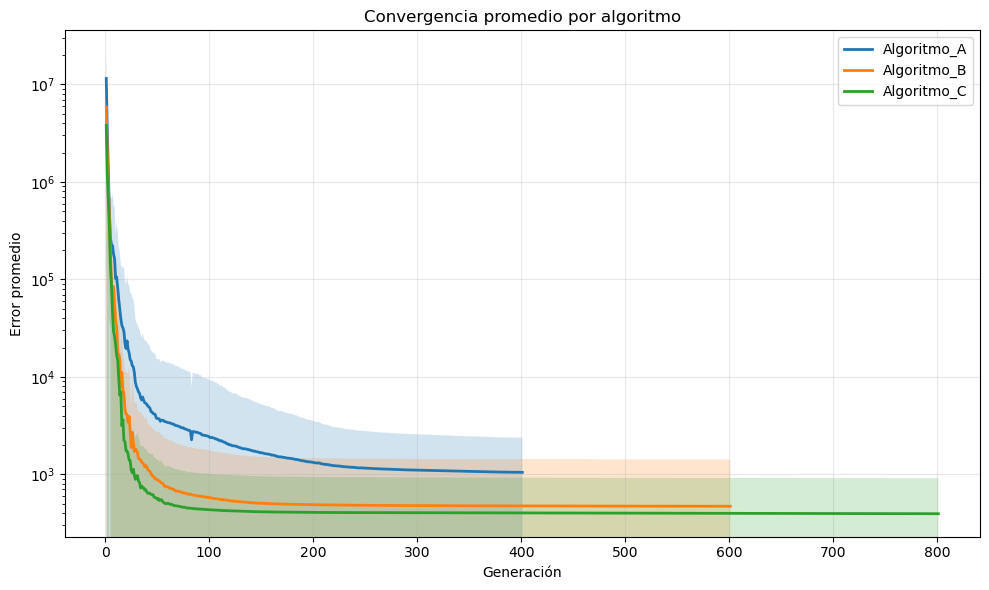

In [ ]:
# --- 10. Convergencia promedio ---

# Armamos una función para graficar la convergencia promedio
def plot_average_convergence(curves_list, label):
    """Grafica la convergencia promedio con banda de desviación estándar."""
    max_len = max(len(c) for c in curves_list)
    padded_curves = [c + [c[-1]] * (max_len - len(c)) for c in curves_list]
    avg_curve = np.mean(padded_curves, axis=0)
    std_curve = np.std(padded_curves, axis=0)
    gens = np.arange(1, max_len + 1)
    plt.plot(gens, avg_curve, label=label, linewidth=2)
    plt.fill_between(gens, avg_curve - std_curve, avg_curve + std_curve, alpha=0.2)

plt.figure(figsize=(10, 6))
plot_average_convergence(curves_A, 'Algoritmo_A')
plot_average_convergence(curves_B, 'Algoritmo_B')
plot_average_convergence(curves_C, 'Algoritmo_C')
plt.xlabel("Generación")
plt.ylabel("Error promedio")
plt.title("Convergencia promedio por algoritmo")
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Mejor solución encontrada


MEJOR SOLUCIÓN GENERAL
Mejor algoritmo: Algoritmo_B
Error mínimo: 6.763710e-03
Coeficientes: a=-0.060048, b=2.039119, c=-15.645086, d=24.648493


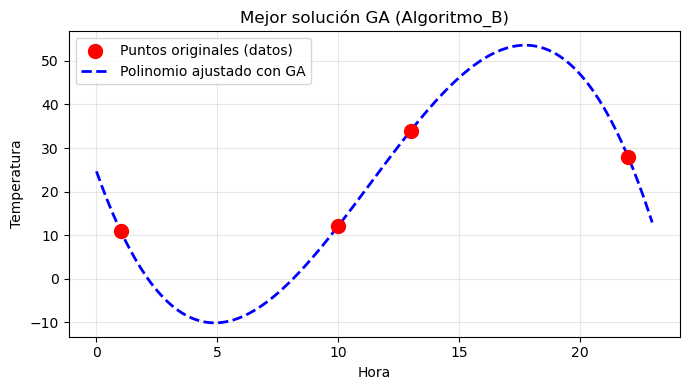

In [59]:
# --- 11. Mejor solución general ---
print("\n" + "="*60)
print("MEJOR SOLUCIÓN GENERAL")
print("="*60)

# Determinar cuál algoritmo tuvo el mejor resultado
best_errors = [np.min(errors_A), np.min(errors_B), np.min(errors_C)]
best_algo_idx = np.argmin(best_errors)
best_algo_names = ['Algoritmo_A', 'Algoritmo_B', 'Algoritmo_C']
best_coefs = [coef_A, coef_B, coef_C]

print(f"Mejor algoritmo: {best_algo_names[best_algo_idx]}")
print(f"Error mínimo: {best_errors[best_algo_idx]:.6e}")

a, b, c, d = best_coefs[best_algo_idx]
print(f"Coeficientes: a={a:.6f}, b={b:.6f}, c={c:.6f}, d={d:.6f}")
plot_solucion(best_coefs[best_algo_idx], points, 
              f"Mejor solución GA ({best_algo_names[best_algo_idx]})")


#### Validación del mejor algoritmo encontrado con datos de prueba

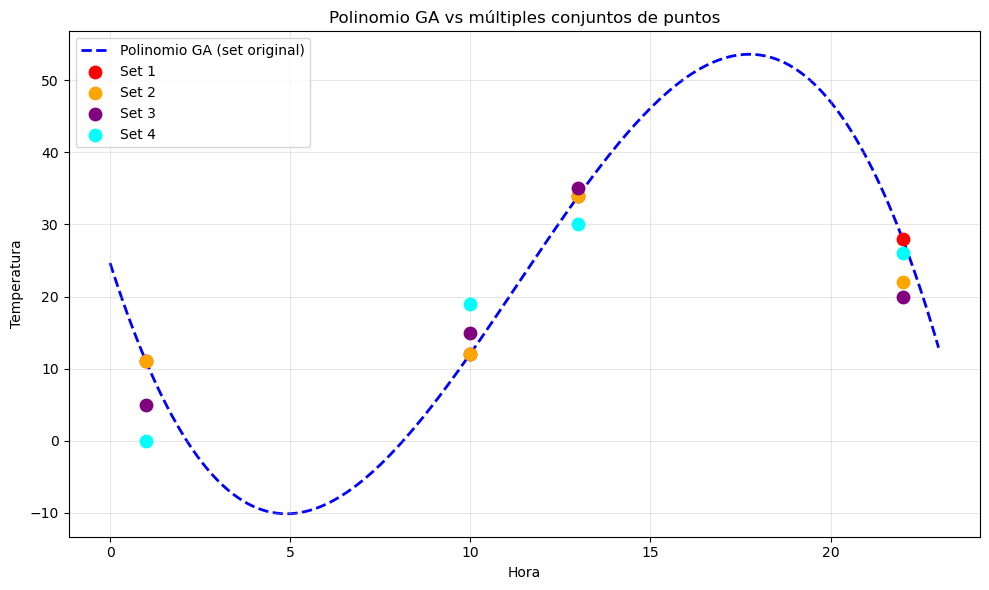


ERRORES POR CONJUNTO DE PUNTOS
  Set  Error Total      Punto 1      Punto 2      Punto 3      Punto 4
Set 1 6.763710e-03 3.069761e-04 3.840531e-03 2.603802e-03 1.240122e-05
Set 2 3.604902e+01 3.069761e-04 3.840531e-03 2.603802e-03 3.604227e+01
Set 3 1.095831e+02 3.579006e+01 8.632008e+00 1.104659e+00 6.405636e+01
Set 4 1.883596e+02 1.206149e+02 4.813623e+01 1.559438e+01 4.014099e+00


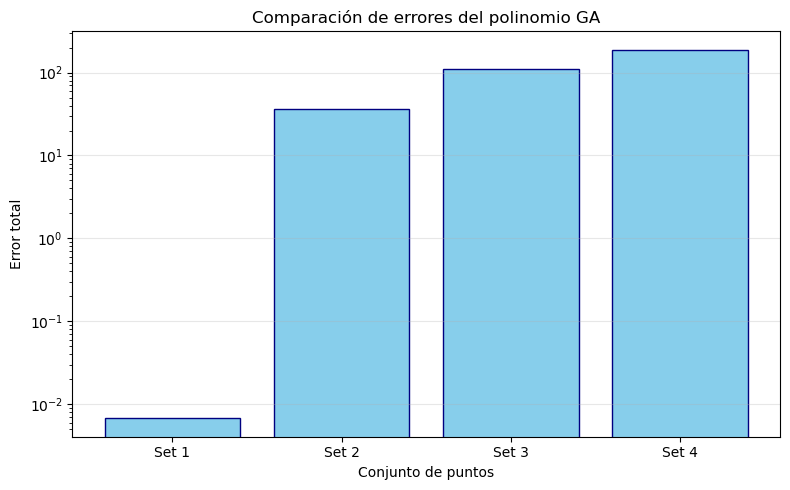

In [60]:
# --- 12. Validación con otros conjuntos de puntos ---
point_sets = [
    [(1, 11), (10, 12), (13, 34), (22, 28)],  # Original
    [(1, 11), (10, 12), (13, 34), (22, 22)],   
    [(1, 5), (10, 15), (13, 35), (22, 20)], 
    [(1, 0), (10, 19), (13, 30), (22, 26)]
]

xs = np.linspace(0, 23, 200)
ys_ga = a * xs**3 + b * xs**2 + c * xs + d

plt.figure(figsize=(10, 6))
colors = ['red', 'orange', 'purple', 'cyan']

plt.plot(xs, ys_ga, color='blue', linestyle='--', 
         label='Polinomio GA (set original)', linewidth=2, zorder=1)

for idx, pts in enumerate(point_sets):
    plt.scatter([x for x, _ in pts], [y for _, y in pts], 
               color=colors[idx], label=f'Set {idx+1}', s=80, zorder=2)

plt.legend()
plt.xlabel("Hora")
plt.ylabel("Temperatura")
plt.title("Polinomio GA vs múltiples conjuntos de puntos")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Tabla de errores por conjunto
errors_data = []
for idx, pts in enumerate(point_sets, 1):
    error_total = 0.0
    individual_errors = []
    for x, y in pts:
        y_pred = a*x**3 + b*x**2 + c*x + d
        err = (y - y_pred)**2
        individual_errors.append(err)
        error_total += err
    
    errors_data.append({
        'Set': f'Set {idx}',
        'Error Total': f"{error_total:.6e}",
        'Punto 1': f"{individual_errors[0]:.6e}",
        'Punto 2': f"{individual_errors[1]:.6e}",
        'Punto 3': f"{individual_errors[2]:.6e}",
        'Punto 4': f"{individual_errors[3]:.6e}"
    })

df_errors = pd.DataFrame(errors_data)
print("\n" + "="*60)
print("ERRORES POR CONJUNTO DE PUNTOS")
print("="*60)
print(df_errors.to_string(index=False))

# Gráfico de barras
plt.figure(figsize=(8, 5))
errors_total = [sum((a*x**3 + b*x**2 + c*x + d - y)**2 for x, y in pts) 
                for pts in point_sets]
sets = [f'Set {i+1}' for i in range(len(point_sets))]
plt.bar(sets, errors_total, color='skyblue', edgecolor='navy')
plt.xlabel("Conjunto de puntos")
plt.ylabel("Error total")
plt.title("Comparación de errores del polinomio GA")
plt.yscale('log')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()